# Emmons Glacier Analysis

This code will read in our geocoded and cropped SAR images over the Muldrow Glacier, sort them by dates, zoom in on our area of interest, and create a time series gif of the glacier motion. The next step here is to import openCV and try out the dense optical flow algorithm to extract velocity fields.

In [12]:
import geopandas as gpd
import os
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [13]:
geo_crop_dir = '/home/jovyan/glacier-thickness-from-sar/import_data/sar_images_geocoded_cropped'

In [14]:
emmonds = gpd.read_file('/home/jovyan/glacier-thickness-from-sar/import_data/glacier_shapefile/emmons_glacier.geojson')

## Extract dates from files and sort SAR images by date

In [15]:
file_list = []
date_list = []
for file in os.listdir(geo_crop_dir):
    if file != '.ipynb_checkpoints':
        file_list.append(file)
        date = pd.to_datetime(file[14:29])
        date_list.append(date)

In [16]:
date_list.sort()
file_list.sort()

## Take the log of each SAR image and display with accompanying colorbar

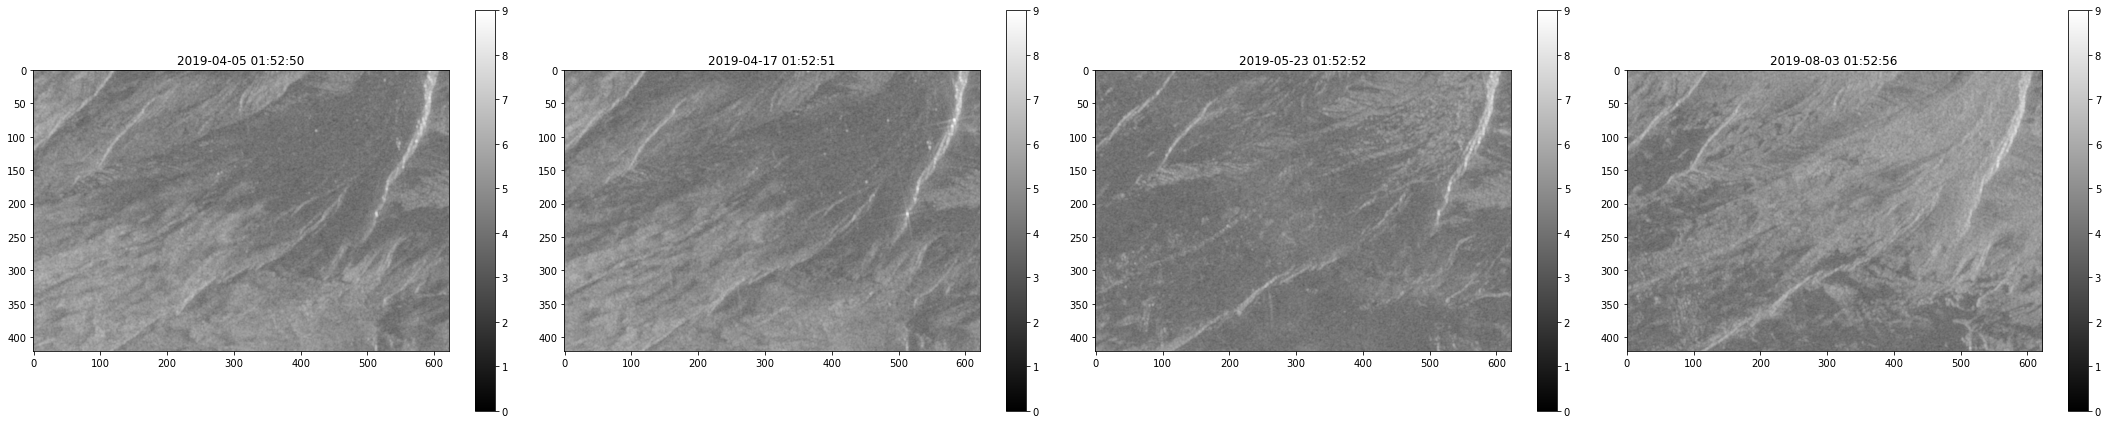

In [32]:
f,ax=plt.subplots(1,len(file_list),figsize=(30,6))
for i,file in enumerate(file_list):
    sar_image = plt.imread(f'{geo_crop_dir}/{file}')
    sar_image_log = np.log(sar_image,where=(sar_image!=0))
    color = ax[i].imshow(sar_image_log,cmap='gray',vmin=0,vmax=9)
    ax[i].set_title(date_list[i])
    f.colorbar(color,ax=ax[i])
plt.tight_layout()

## Create and save a gif of the SAR time series stack

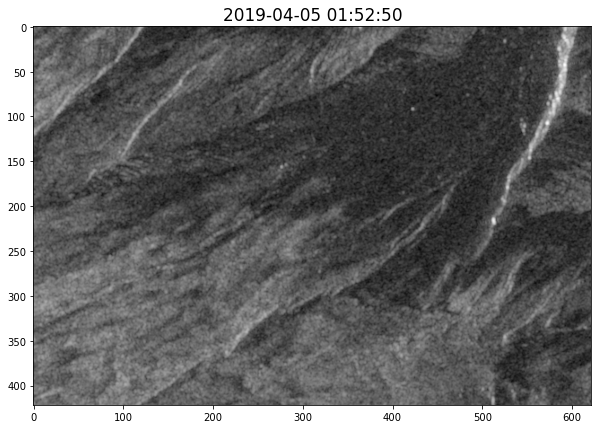

In [33]:
f,ax=plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 14})

sar_image = plt.imread(f'{geo_crop_dir}/{file_list[0]}')
im = ax.imshow(np.log(sar_image,where=(sar_image!=0)),cmap='gray')
ax.set_title(date_list[0])

def update(frame):
    sar_image = plt.imread(f'{geo_crop_dir}/{file_list[frame]}')
    sar_image_log = np.log(sar_image,where=(sar_image!=0))
    im.set_data(sar_image_log)
    ax.set_title(date_list[frame])
    ax.axis('equal')


ani = FuncAnimation(f, update, frames=len(file_list), blit=False, interval=300)

In [34]:
HTML(ani.to_jshtml())

In [35]:
ani.save('emmons_timeseries.gif', writer='pillow', fps=2)

In [36]:
#TODO: create notebooks to try out different approaches
# whatever way we learn in class
# look at opencv tools, for example: https://docs.opencv.org/master/d7/df3/group__imgproc__motion.html
# speckle offset tracking
# https://mudic.readthedocs.io/en/latest/examples/example.html
# for validation: https://docs.terradue.com/ellip/solutions/notebooks/examples/polar/resources/code/polarstern/04-glacier-velocity.html
# ...

## Dense Optical Flow



In [37]:
import glob
import cv2 as cv
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt

dims = cv.imread(f'{geo_crop_dir}/{file_list[0]}')
first_frame = cv.imread(f'{geo_crop_dir}/{file_list[0]}',cv.IMREAD_UNCHANGED)

prev_frame = np.log(first_frame,where=(first_frame!=0))
mask = np.zeros_like(dims)
mask[..., 1] = 255

f,ax=plt.subplots(len(file_list),2,figsize=(20,80))
for i, filename in notebook.tqdm(enumerate(file_list)):  
    frame = cv.imread(f'{geo_crop_dir}/{filename}',cv.IMREAD_UNCHANGED)
    gray = np.log(frame,where=(frame!=0))

    colorb = ax[i,0].imshow(gray,vmin=0,vmax=9,cmap='gray')
    f.colorbar(colorb,ax=ax[i,0])
    ax[i,0].set_title(date_list[i])
    
    
    flow = cv.calcOpticalFlowFarneback(prev_frame, frame, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.1, 0)
      
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

    mask[..., 0] = angle * 180 / np.pi / 2
      
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    #ax[i,1].imshow(rgb)
    colorb2 = ax[i,1].imshow(magnitude*(10/12),vmin=0,vmax=25,cmap='jet') 
    cbar = f.colorbar(colorb2,ax=ax[i,1])
    cbar.set_label('velocity [m/day]', rotation=270)
    if i == 0:
      ax[i,1].set_title('blank')
    else:
      ax[i,1].set_title(f'{date_list[i-1]} to {date_list[i]}')
      
    prev_frame = frame

ModuleNotFoundError: No module named 'cv2'